<a href="https://colab.research.google.com/github/selcancelikel/bitirmeprojesi/blob/main/pathlstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.2909 - val_loss: 0.1622
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1189 - val_loss: 0.0909
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0906 - val_loss: 0.0876
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0875 - val_loss: 0.0842
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0841 - val_loss: 0.0798
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0796 - val_loss: 0.0733
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0727 - val_loss: 0.0647
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0654 - val_loss: 0.0608
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0621 - val_loss: 0.0585
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0594 - val_loss: 0.0550
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0561 - val_loss: 0.0518
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/ste

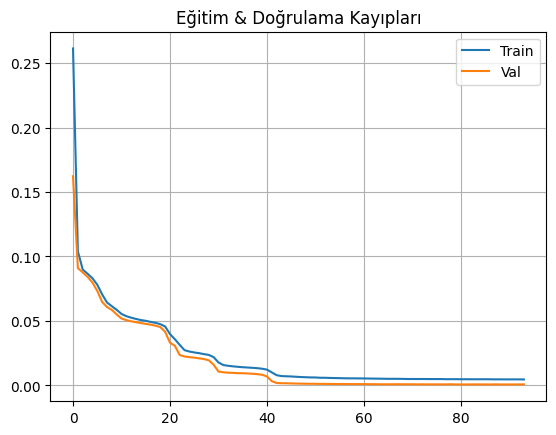

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Eşik Değeri: 0.00191
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     12000
           1       0.78      0.72      0.75      3000

    accuracy                           0.90     15000
   macro avg       0.86      0.84      0.85     15000
weighted avg       0.90      0.90      0.90     15000


=== Confusion Matrix ===
[[11400   600]
 [  838  2162]]
ROC AUC: 0.9189716388888889


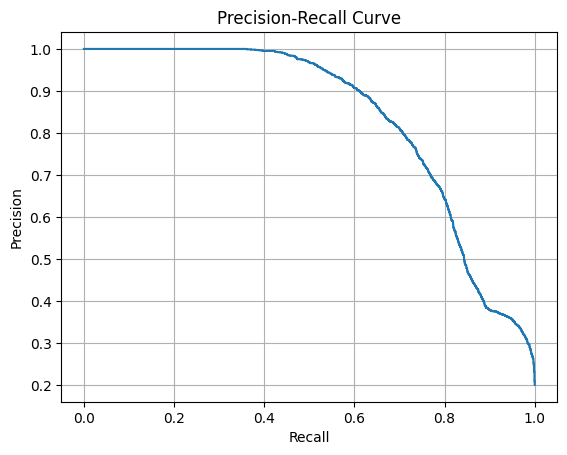

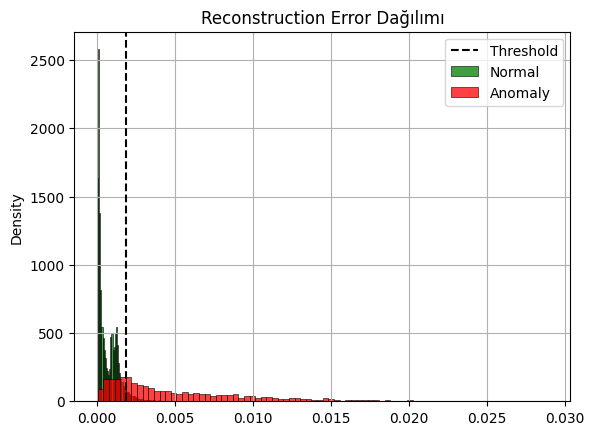


Toplam Doğruluk: 0.9041
Tamamlandı: 2025-06-26 10:45:45


In [ ]:
# === GEREKLİ KÜTÜPHANELER ===
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# === ORTAM AYARLARI ===
pd.set_option('display.max_columns', None)
tf.random.set_seed(42)
np.random.seed(42)

# === VERİYİ YÜKLE ===
df = pd.read_csv("realistic_anomaly_dataset.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# === EK ZAMAN ÖZNİTELİKLERİ ===
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# === DİZİN DERİNLİĞİ ===
df['dir_depth'] = df['file_path'].str.count('/')

# === LABEL ENCODING ===
enc_cols = ['user_id', 'action', 'file_path']
encoders = {col: LabelEncoder() for col in enc_cols}
for col in enc_cols:
    df[col + '_enc'] = encoders[col].fit_transform(df[col])

# === ÖZNİTELİK SEÇİMİ ===
features = ['user_id_enc', 'action_enc', 'file_path_enc', 'hour', 'dayofweek', 'is_weekend', 'dir_depth']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df['label'].values

# === LSTM GİRİŞ FORMATINA GETİR ===
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train = X_scaled[y == 0]
X_test = X_scaled
y_test = y

# === LSTM AUTOENCODER MODELİ ===
def build_lstm_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32, return_sequences=False),
        layers.RepeatVector(1),
        layers.LSTM(32, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64, return_sequences=True),
        layers.TimeDistributed(layers.Dense(input_shape[1]))
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_lstm_model(X_train.shape[1:])
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# === MODEL EĞİTİMİ ===
history = model.fit(X_train, X_train,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[early_stop],
                    verbose=1)

# === KAYIP GRAFİĞİ ===
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend(); plt.title("Eğitim & Doğrulama Kayıpları")
plt.grid(); plt.show()

# === EŞİK BELİRLEME ===
recon_train = model.predict(X_train)
mse_train = np.mean(np.square(X_train - recon_train), axis=(1,2))
threshold = np.percentile(mse_train, 95)
print(f"Eşik Değeri: {threshold:.5f}")

# === TAHMİN VE METRİKLER ===
recon_test = model.predict(X_test)
mse_test = np.mean(np.square(X_test - recon_test), axis=(1,2))
y_pred = (mse_test > threshold).astype(int)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, mse_test))

# === PR EĞRİSİ ===
precision, recall, _ = precision_recall_curve(y_test, mse_test)
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.grid(True)
plt.show()

# === RECONSTRUCTION ERROR GRAFİĞİ ===
sns.histplot(mse_test[y_test == 0], bins=80, color='green', label='Normal', stat='density')
sns.histplot(mse_test[y_test == 1], bins=80, color='red', label='Anomaly', stat='density')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Dağılımı")
plt.legend(); plt.grid(); plt.show()

# === ÖZET ===
accuracy = (y_pred == y_test).mean()
print(f"\nToplam Doğruluk: {accuracy:.4f}")
print("Tamamlandı:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
